In [1]:
#!pip install clustergram pandas_profiling scipy sklearn statsmodels IPython dtale matplotlib rpy2 seaborn shap

In [2]:
#put in ~/.bashrc
#LD_PRELOAD="/mnt/distvol/R/4.1.2/lib64/R/lib/LibR.so"

In [3]:
#from fracdiff import fdiff
#import urbangrammar-graphics as ugg
%matplotlib inline
import os
from clustergram import Clustergram
from concurrent.futures import wait, ALL_COMPLETED
from dask.distributed import Client
from dask.distributed import as_completed
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from numpy import absolute
from numpy import arange
from numpy import mean
from numpy import std
from pandas import read_csv
from pandas_profiling import ProfileReport
#from rpy2.robjects import pandas2ri
from pmdarima.utils import diff_inv
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.packages import importr
from rpy2.rinterface_lib import openrlib
from scipy import stats
from scipy.cluster.vq import vq
from scipy.spatial.distance import cdist, pdist
from scipy.special import boxcox, inv_boxcox
from scipy.stats import f
from sklearn import preprocessing
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import *
#from sklearn.preprocessing import PowerTransformer
#from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import scale
from sklearn.utils import as_float_array
from statsmodels.formula.api import ols
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.outliers_influence import OLSInfluence
import statsmodels.api as sm
import IPython
import concurrent.futures
import dask.dataframe as dd
import datetime
import dtale
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pingouin as pg
import pmdarima
import pycorrelate
import random
import re
import rpy2
import rpy2.robjects as ro
import rpy2.situation
import scipy
import seaborn as sn
import shap
import sklearn
import sklearn.linear_model
import statsmodels.api as sm
import statsmodels.tools
import sys
import time

In [4]:
#c = get_config()
libpath = os.environ.get('LD_LIBRARY_PATH', '')
os.environ['LD_LIBRARY_PATH'] = (
    rpy2.situation.r_ld_library_path_from_subprocess(openrlib.R_HOME) +
    libpath
)

In [5]:
def formula_from_cols(df, y):
    return y + ' ~ ' + ' + '.join([col for col in df.columns if not col==y])

def testNormal (x):    
    
    k2, p = stats.normaltest(x)
    alpha = .001
    #print("p = {:g}".format(p))    
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        #print(p)
        #print(alpha)
        print("The null hypothesis can be rejected")
        xt, _ = stats.yeojohnson(x)
        #xt, _ = stats.boxcox(x)        
        print(_)
        xt = pd.DataFrame(xt)
        
        return _, pd.DataFrame(xt).set_index(x.index)
    else:
        print("The null hypothesis cannot be rejected")    
        return 1, pd.DataFrame(x)

def inverse_boxcox (data, lambdas):
    power = PowerTransformer(method='yeo-johnson')
    power.lambdas_ = lambdas.values
    return(power.inverse_transform([data]))
    #return inv_boxcox(data, lambdas.values)
    
def transform_boxcox_l(data, l_):
    transformed = pd.DataFrame()

    for i in range(0,len(data.columns)):
        #print(i)
        if l_.iloc[i].values == 1:
            inner_scale = data.iloc[:,i]            
        else:
            inner_scale = pd.DataFrame(stats.yeojohnson((data.iloc[:,i]), lmbda=l_.iloc[i].values))
            
        inner_scale.index = data.index
        transformed = pd.concat([transformed,inner_scale],axis=1)
        
    transformed.columns = data.columns
    return transformed

def transform_boxcox (data):
    transformed = pd.DataFrame()
    transformed_lambdas = pd.DataFrame()

    for i in range(0,len(data.columns)):
        l, inner_scale = testNormal(data.iloc[:,i])
        inner_scale.set_index(data.index)

        transformed_lambdas = pd.concat([transformed_lambdas,pd.DataFrame(pd.Series(l))],axis=0)
        transformed = pd.concat([transformed,inner_scale],axis=1)
        
    transformed.columns = data.columns
    return transformed, transformed_lambdas

def inverse_yeo(og, data_, lambda_):
    values = []
    for i in range(0,len(og)):
        X = og[i]
        X_trans = data_[i]
        if X >= 0 and lambda_ == 0:
            X = exp(X_trans) - 1
        elif X >= 0 and lambda_ != 0:
            X = (X_trans * lambda_ + 1) ** (1 / lambda_) - 1
        elif X < 0 and lambda_ != 2:
            X = 1 - (-(2 - lambda_) * X_trans + 1) ** (1 / (2 - lambda_))
        elif X < 0 and lambda_ == 2:
            X = 1 - exp(-X_trans)
        
        values.append(X)
    return(pd.DataFrame(values))


def revert_yeo (og, data_, lambdas):
    reverted = pd.DataFrame()

    for i in range(0,len(data_.columns)):        
        if lambdas.iloc[i].values == 1 :
            revert = data_.iloc[:,i]
        else:
            p#ower = PowerTransformer(method='yeo-johnson')
            #power.lambdas_ = lambdas.iloc[i].values
            #revert = pd.DataFrame(power.inverse_transform([data.iloc[:,i].values]))
            #return inv_boxcox(data, lambdas.values)
            revert = pd.DataFrame(inverse_yeo(og.iloc[:,i].values,data_.iloc[:,i].values, lambdas.iloc[i].values))            
        revert.index = data_.index
        reverted = pd.concat([reverted,revert],axis=1)
        
    reverted.columns = data_.columns
    return reverted

class ZCA(BaseEstimator, TransformerMixin):
  def __init__(self, regularization=1e-5, copy=False):
      self.regularization = regularization
      self.copy = copy
  def fit(self, X, y=None):
      X = as_float_array(X, copy=self.copy)
      self.mean_ = np.mean(X, axis=0)
      X = X - self.mean_
      sigma = np.dot(X.T, X) / (X.shape[0] - 1)
      U, S, V = np.linalg.svd(sigma)
      tmp = np.dot(U, np.diag(1 / np.sqrt(S + self.regularization)))
      self.components_ = np.dot(tmp, U.T)
      return self
  def transform(self, X):
      X_transformed = X - self.mean_
      X_transformed = np.dot(X_transformed, self.components_.T)
      return X_transformed

def crosscorrelation(x, y, maxlag, mode='corr'):
    """
    Cross correlation with a maximum number of lags.

    `x` and `y` must be one-dimensional numpy arrays with the same length.

    This computes the same result as
        numpy.correlate(x, y, mode='full')[len(a)-maxlag-1:len(a)+maxlag]

    The return vaue has length 2*maxlag + 1.
    """
    py = np.pad(y.conj(), 2*maxlag, mode='constant')
    T = np.lib.stride_tricks.as_strided(py[2*maxlag:], shape=(2*maxlag+1, len(y) + 2*maxlag),
                   strides=(-py.strides[0], py.strides[0]))
    px = np.pad(x, maxlag, mode='constant')
    if mode == 'dot':       # get lagged dot product
        return T.dot(px)
    elif mode == 'corr':    # gets Pearson correlation
        return (T.dot(px)/px.size - (T.mean(axis=1)*px.mean())) / \
               (np.std(T, axis=1) * np.std(px)) 
    
def ret_ccf(npa_):
    y_name = npa_[0]
    x_name = npa_[1]
    data = cleaned.loc[training]
    y = np.array(data.iloc[:,data.columns==y_name]).ravel()
    
    x = np.array(data.iloc[:,data.columns==x_name]).ravel()
    #print(x)
    #ccf = statsmodels.tsa.stattools.ccf(x,y)
    ccf = crosscorrelation(x,y, ccf_max_lag, mode='corr')
    #print(ccf)
    return([y_name,x_name,ccf])

def train(partition):
    est = LinearRegression()
    est.fit(partition[New_Names].values, partition['target'])
    return est


def regress (df):
    lr = LinearRegression()

    variables=df.columns
    target = variables[0]
    
    temp = pd.concat([pd.DataFrame(df[target]),df.loc[:, ~df.columns.isin([target])]],axis=1)

    name = str(target)+'.csv'
    #print(name)
    
    s_f_s = sfs(lr, 
              k_features=len(df.columns)-1, 
              forward=True, 
              floating=False, 
              scoring='neg_mean_squared_error',
              n_jobs=-1,
              cv=10)
    
    s_f_s_f = s_f_s.fit(temp.loc[:, ~temp.columns.isin([target])], pd.DataFrame(temp[target]))
    
    #temp.to_csv(name)
    return(s_f_s_f.get_metric_dict())
    '''
def nv_diff_sets(v_of_i,dataset,f_casts):

  s_=sndif_[which(colnames(raw)==var_of_int)]
  d_=ndif_[which(colnames(raw)==var_of_int)]
  
  startRow = c()
  for (r in rownames(dataset[1:d_,,drop=FALSE])):
    startRow = c(startRow,which(rownames(raw)==r))
  
  data_ = c(na.omit(c(dataset[,var_of_int], f_casts)))
  
  if(s_==0):
    inv_d = diffinv(data_,differences=d_,xi=raw[startRow,var_of_int])
  else:  
    inv_d = diffinv(diffinv(data_,differences = d_, xi=raw[startRow,var_of_int]), differences = s_,xi=raw[startRow:(startRow+season-1),var_of_int])
    
  return(inv_d)
'''

def lagpad(x, k):
    length=np.full(abs(k), np.NaN)
    #print(length)
    #k=k-1
    if (k>0):
        result = np.concatenate([length,x[0:(len(x)-k)]])
    elif (k<0):
        result= np.concatenate([(x[abs(k):(len(x))]),length])
    else:
        result= x
    return(result)

def lag(data):
    return lagpad(data,1)

def sndif_(npa_):
    data = raw_int[npa_[0]]
    return(pmdarima.arima.nsdiffs(data.dropna(),m=npa_[1]))

def ndif_(npa_):
    data = raw_int[npa_[0]]
    return(pmdarima.arima.ndiffs(data.dropna()))

def clientFunction(function_name,npa):
    client = Client('192.168.3.100:8786',timeout=3)
    future = client.map(function_name,npa)

    results = []
    for f in as_completed(future):
        if(f.status=="error"):
            results.append("error")
        else:
            results.append(f.result())   

    client.close()

    return results

In [6]:
tscv = TimeSeriesSplit(n_splits = 5)

In [7]:
raw = pd.read_csv("all_data.csv",index_col=0)
raw.index = pd.to_datetime(raw.index)

#fillna(method='bfill')
raw_int = raw.interpolate(method='time').dropna()


In [8]:
#delta = (raw_int-raw_int.shift()).dropna()
#raw_delta = (raw_int - raw_int.apply(lag,0)).dropna()
#raw_delta.head()

#raw_delta.isna().sum().sum()

In [9]:

#for i in range(0,len(raw_int.columns)):
        
#np.max(sndif)

In [10]:
#raw_int.diff().dropna().apply(pmdarima.arima.nsdiffs(m=4))

sndif = []

season = 4
maxn = season

npa = []

for s in range(0,len(raw_int.columns)):
    npa.append([raw_int.columns[s],maxn, ])
    
sndif = clientFunction(sndif_,npa)    

In [11]:
ndif = []

npa = []

for s in range(0,len(raw_int.columns)):
    npa.append([raw_int.columns[s]])
    
ndif = clientFunction(ndif_,npa)           

In [12]:
#doesn't preserve na's...
#len(pmdarima.utils.diff(temp,1,1).ravel())

deseasoned = pd.DataFrame()
for i in range(0,len(raw_int.columns)):
    if(sndif[i]*season == 0):
        temp = raw_int.iloc[:,[i]]
    else:
        temp = raw_int.iloc[:,[i]]
        if(sndif[i]>0):
            for d in range(0,sndif[i]):
                temp = pd.DataFrame(temp.values.ravel()-lagpad(temp.values.ravel(),1*season)).set_index(temp.index)
                temp.columns = raw_int.iloc[:,[i]].columns
    deseasoned = pd.concat([deseasoned,temp],axis=1)


In [13]:
#for d in deseasoned.columns:
    #print(d)

In [14]:
deseasoned_differenced = pd.DataFrame()

for i in range(0,len(raw_int.columns)):
    temp_ = deseasoned.iloc[:,[i]]
    colnames = temp_.columns
    if ndif[i]>0:
        #print(ndif[i])
        for d in range(0,ndif[i]):
            #print(d)
            #
            #print(temp_.columns)
            #temp_ = pd.DataFrame(temp_.values.ravel()-lagpad(temp_.values.ravel(),1)).set_index(temp_.index)
            #temp_.columns = colnames
            temp = temp_.diff()
    temp.columns = temp_.columns
    deseasoned_differenced = pd.concat([deseasoned_differenced,temp],axis=1)


In [15]:
#for d in deseasoned_differenced.columns:
    #print(d)

In [16]:
deseasoned_differenced.interpolate(method='time').isna().sum().sum()
#.fillna(method='bfill')
#raw_int = raw.dropna()


308

In [17]:
deseasoned_differenced.describe()

,ASPUS,AWHAETP,BAA10Y,BACDINA066MNFRBNY,BACTSAMFRBDAL,BAMLC0A0CM,BAMLCC0A1AAATRIV,BAMLCC0A4BBBTRIV,BAMLH0A3HYC,BAMLHYH0A0HYM2TRIV,...,VZ,W5000FLT,WBA,WEAT,WMT,XDOC,XLB,XLC,XLI,XLP
count,55.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,...,54.000000,54.000000,54.000000,54.000000,54.000000,50.000000,54.000000,54.000000,54.000000,54.000000
mean,48.203408,0.004938,-0.021673,0.616049,0.730864,-0.029071,6.546679,10.861154,-0.092833,18.254586,...,1.777626,0.218162,0.744255,2.831459,0.744255,0.824150,1.222605,0.876687,3.710815,0.999061
std,30.314248,0.080201,0.453094,16.642048,14.135217,0.540044,13.975538,18.474739,3.406872,37.436962,...,4.546572,2.977538,3.116071,6.093759,3.116071,5.503900,7.873159,2.604406,7.262683,8.605673
min,6.983253,-0.200000,-1.504410,-64.233333,-31.233333,-1.678937,-25.510096,-50.098550,-9.396154,-139.901796,...,-8.272926,-10.610158,-7.288573,-5.146033,-7.288573,-13.523993,-22.058186,-5.179459,-14.060353,-20.193453
25%,22.840995,-0.033333,-0.192754,-6.583333,-7.891667,-0.175614,-4.122416,-0.649419,-1.334322,2.758185,...,-0.751921,-1.655371,-0.720025,-0.261821,-0.720025,-2.081028,-2.655422,-0.928805,-0.645171,-4.389770
50%,39.592402,0.000000,-0.033490,0.416667,0.083333,-0.053672,7.569685,12.211152,-0.194841,22.699687,...,1.689364,0.880039,0.618146,1.524660,0.618146,0.008430,2.650421,0.867217,2.709435,2.432004
75%,64.783303,0.033333,0.144554,6.008333,9.291667,0.078655,15.460935,20.345925,0.917954,34.930997,...,4.331338,2.143258,2.035942,3.837932,2.035942,3.527494,6.389959,2.541639,5.709335,5.977480
max,116.314493,0.233333,2.237218,56.766667,48.966667,2.784677,42.598631,60.558266,17.539328,97.333375,...,16.379358,5.889132,11.005911,28.643387,11.005911,20.736461,18.043609,6.931687,22.355501,21.302764


In [18]:
#for d in deseasoned_differenced.columns:
    #print(d)

In [19]:
#https://machinelearningmastery.com/time-series-data-stationary-python/
cleaned = deseasoned_differenced.interpolate(method='time').dropna()


In [20]:
#plt.plot(cleaned.iloc[:,0])

<AxesSubplot:>

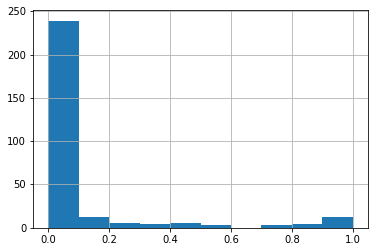

In [21]:
#How many are stationary?
%matplotlib inline
pd.DataFrame(cleaned.apply(adfuller).iloc[1,]).iloc[:,0].hist()

In [22]:
#for d in cleaned.columns:
    #print(d)

In [23]:
indexes = train_test_split(cleaned.index, test_size=.5, random_state=0, shuffle=False)

In [24]:
test_sets = []

for i in indexes:
    test_sets.append(cleaned.index.difference(i))
    
training = indexes[0]
testing = indexes[1]

In [25]:
#np.cumsum(x_names=='BOGZ1FL105015105Q')

In [26]:
#len(cleaned.iloc[:,raw.columns=='BACDINA066MNFRBNY'])

In [27]:
ccf_max_lag = 4

#for c in cleaned.columns:
    #print(y_name)


In [28]:
ccf_ = []

npa = []

chosen = cleaned.columns[random.randint(0,len(cleaned.columns)-1)]
print(chosen)
y_name = cleaned.columns[cleaned.columns==chosen].values[0]
#x_names = cleaned.columns[(cleaned.columns!=cleaned.columns[0])]
x_names = cleaned.columns

for s in range(0,len(x_names)):
    #y_name = y_name_
    x_name = x_names[s]
    #print(x_name)
    npa.append([y_name,x_name])
    
ccf_ = clientFunction(ret_ccf,npa)

y = np.array(cleaned.iloc[:,cleaned.columns==y_name]).ravel()
x = y
#last one is for comparing with itsel to ensure 0 lag ccf is 1
ccf_.append([y_name,y_name,crosscorrelation(x,y, ccf_max_lag, mode='corr')])
#ccf_.append([np.array([y_name,y_name]).reshape(2,1),crosscorrelation(x,y, 4, mode='corr')])#


EFV


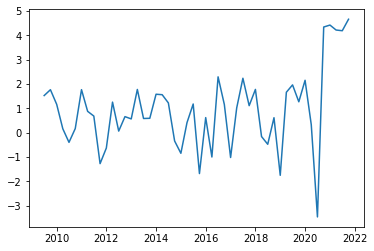

In [29]:
%matplotlib inline
plt.plot(cleaned[chosen])

In [30]:
range_ = [*range(-ccf_max_lag,ccf_max_lag+1)].copy()

ccf_scores = pd.DataFrame()

for c in ccf_:
    #print(c)
    y = c[0]
    x = c[1]
    #print(x)
    ar_ = pd.DataFrame(c[2])
    #print(ar_)
    ar_.index = range_
    ar_.columns = [x]
    #abs(ar_)
    ccf_scores = pd.concat([ccf_scores,ar_],axis=1)
    
    

In [31]:
#len(ccf_scores.columns)

In [32]:
#derive optimally lagged dataset

data_final = pd.DataFrame()

best_lags = []
#don't want the last one
for c in ccf_scores.columns[:-1]:
    #print(c)
    temp = ccf_scores[ccf_scores.index>0][c]
    bl = ccf_scores.index[ccf_scores.index>0][np.argmax(abs(temp))]
    best_lags.append(bl)
    data = pd.DataFrame(lagpad(cleaned[c],bl))
    data.index = cleaned[c].index
    data.columns = [c]
    data_final = pd.concat([data_final,data],axis=1)


In [33]:
data_final_dask = dd.from_pandas(data_final,npartitions=128)
data_final_dask_w_y = dd.concat([cleaned[[y_name]],data_final_dask.compute()],axis=1)
names_ = ['target']
names_.extend(cleaned.columns)
data_final_dask_w_y.columns = names_

In [34]:
#data_final_dask.apply(np.cumsum,axis=1).compute()


In [35]:
len(data_final.columns)

289

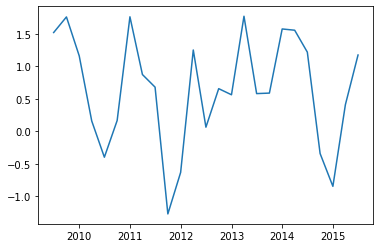

In [36]:
#plt.plot(raw_int[chosen])
#plt.plot(cleaned[chosen])
#plt.plot(data_final_dask_w_y[chosen].compute())
plt.plot(data_final_dask_w_y[['target']].compute().loc[training])

In [37]:
'''
zca1_subset = working_set[subset.columns.difference(['target',max_pname])].dropna()
zca1 = zca.fit(zca1_subset)
zca1_df = pd.DataFrame(zca1.transform(zca1_subset))
zca1_df.columns = zca1_subset.columns
zca1_df.index = zca1_subset.index

zca1_subset = working_set[subset.columns.difference(['target',max_pname])].dropna()
zca1 = zca.fit(zca1_subset)
zca1_df = pd.DataFrame(zca1.transform(zca1_subset))
zca1_df.columns = zca1_subset.columns
zca1_df.index = zca1_subset.index
#pd.concat([target,zca1],axis=1)
'''

"\nzca1_subset = working_set[subset.columns.difference(['target',max_pname])].dropna()\nzca1 = zca.fit(zca1_subset)\nzca1_df = pd.DataFrame(zca1.transform(zca1_subset))\nzca1_df.columns = zca1_subset.columns\nzca1_df.index = zca1_subset.index\n\nzca1_subset = working_set[subset.columns.difference(['target',max_pname])].dropna()\nzca1 = zca.fit(zca1_subset)\nzca1_df = pd.DataFrame(zca1.transform(zca1_subset))\nzca1_df.columns = zca1_subset.columns\nzca1_df.index = zca1_subset.index\n#pd.concat([target,zca1],axis=1)\n"

In [38]:
chosen

'EFV'

In [39]:
#New_Names[np.argmax(np.array(New_Names)==chosen)]

In [40]:
#n = New_Names[3]
#New_Names==n

In [41]:
#New_Names = (data_final_dask_w_y.columns.difference(['target']))


In [42]:
def ts_cv_split (dataset):
    #rmse = []

    both_ = []
    #train_ = []
    #test_ = []
    for train_index, test_index in tscv.split(outer_dataset.index):
        #train_.append(train_index)
        #test_.append(test_index)
        both_.append([train_index,test_index])    
    return(both_)

def return_ts_cv_data (indexes):
    dataset=outer_dataset
    #print(indexes[0])
    return([dataset.iloc[indexes[0]],dataset.iloc[indexes[1]]])

def cv_pcor_check (npa_):
    
    #data = npa_
    n = npa_[2]
    New_Names_testing = list(np.array(New_Names)[(np.array(New_Names)!=n)])
    #print(npa_[0])
    
    #dataset= outer_dataset
    #train_index = npa_[0]
    #print(train_index)
    #test_index = npa_[1]
    
    #I don't need it to do training/test splits, but I had advanced ideas that would apply linear models to a test partition and go with the best error reduction... 
    # but partial correlations are just that except they don't take into consideration training/test partitions

    #target.iloc[training].iloc[train_index]
    subset_train = npa_[0]#dataset.iloc[train_index]
    train_index = subset_train.index
    subset_test = npa_[1]#dataset.iloc[test_index]
    #return(subset_test)
    test_index = subset_test.index
    
    y_reg_train_no_x = LinearRegression().fit(subset_train[New_Names_testing], subset_train['target'])
    y_fore_no_x = y_reg_train_no_x.predict(subset_test[New_Names_testing])
    y_resid_no_x = y_fore_no_x.ravel()-subset_test['target']
    
    x_reg_train_no_x = LinearRegression().fit(subset_train[New_Names_testing], subset_train[n])
    x_fore_no_x = x_reg_train_no_x.predict(subset_test[New_Names_testing])
    x_resid_no_x = x_fore_no_x.ravel()-subset_test[n]
    
    cor_resid = pd.concat([pd.DataFrame(y_resid_no_x),pd.DataFrame(x_resid_no_x)],axis=1).corr()
    #model_name = ols(formula_from_cols(subset, 'target'),data=data_final_dask_w_y[subset.columns].compute().iloc[train_index]).fit()
    #print(model_name.summary())

    #skip y and states
    #set_ = subset.loc[:, ~subset.columns.isin([target])].columns.tolist()
    
    c_value = np.array(cor_resid).ravel()[1]
    
    return(c_value)

def pvalues(n):
    #n = New_Names[0]
    New_Names_testing = list(np.array(New_Names)[(np.array(New_Names)!=n)])

    p_values = pd.DataFrame()
    #inner_c_values = []

    indexes = ts_cv_split(outer_dataset)
    
    data = clientFunction(return_ts_cv_data,indexes)
    #print(data)
    new_data = []
    
    for d in data:
        new_data.append([d[0],d[1],n])
    #inner_c_values = []
    #print(new_data[0][0])
    #print(cv_pcor_check(new_data[0]))
    inner_c_values = clientFunction(cv_pcor_check,new_data)
    #print(inner_c_values)
    #loops
    
    #for d in data:
        #inner_c_values.append(cv_pcor_check(d))

    n_ = len(indexes[1][0]) 

    dist = scipy.stats.beta(n_/2 - 1, n_/2 - 1, loc=-1, scale=2)
    p_value = 2*dist.cdf(-abs(np.mean(inner_c_values)))
    temp = pd.DataFrame([chosen,n,p_value]).T
    temp.columns = ['target','test','p']

    if(np.isnan(p_value)):
        #print(n)
        #print(inner_c_values)
        p_value = 0
    #p_values = pd.concat([p_values,temp],axis=0)
    return(p_value)



In [ ]:
scaler = StandardScaler()

tscv = TimeSeriesSplit(n_splits = 5)

#scaler.fit(np.array(data_final_dask_w_y[['target']].compute().loc[training]).reshape(-1, 1))

New_Names = list(data_final_dask_w_y.columns.difference(['target']))

outer_dataset = data_final_dask_w_y.compute().loc[training].dropna()
target = outer_dataset[['target']]

subset = pd.concat([target,outer_dataset[New_Names]],axis=1)

num_folds = 2
#kfold = KFold(n_splits=num_folds, shuffle=False)
#train, test = kfold.get_n_splits(outer_dataset.index)

p_threshold = .05

iteration = 0
max_pvalue = 1

while(max_pvalue>=.05):
#
    n_p_values = pd.DataFrame()

    print(chosen)

    p_values = []
    #parallelize here (x16)
    for n in New_Names:
        #print(n)
        New_Names_testing = list(np.array(New_Names)[(np.array(New_Names)!=n)])
        p_values.append(pvalues(n))

    p_values_df = pd.DataFrame(p_values,index=New_Names)

    max_pname = New_Names[np.argmax(p_values_df)]
    max_pvalue = p_values[np.argmax(p_values_df)]

    #n_p_values = pd.concat([n_p_values,p_values],axis=0)
    #print(n_p_values)

    if (max_pvalue > .05):
        print([max_pname, max_pvalue])
        #New_Names.remove(max_pname)
        #New_Names_testing = list(np.array(New_Names_testing)[(np.array(New_Names_testing)!=max_pname)])
        New_Names = list(np.array(New_Names)[(np.array(New_Names)!=max_pname)])
        temp = ['target']
        temp.extend(New_Names)
        subset = subset[temp]


#print(p_values)
#p_values_train = 
#p_values_test = pd.DataFrame(2*dist.cdf(-abs(subset_test.pcorr()['target']))).T

#p_values = (p_values_train + p_values_test)/2
#p_values.columns = list(subset.columns)


#check correlation of residuals
#print(p_values)        


        

EFV
AAPL
ABCM
ALFIW
ALPN
AMCIW
ASPUS
ATAX
AVAV
AVYA
AWHAETP
AXP
BAA10Y
BACDINA066MNFRBNY
BACTSAMFRBDAL
BAMLC0A0CM
BAMLCC0A1AAATRIV
BAMLCC0A4BBBTRIV
BAMLH0A3HYC
BAMLHYH0A0HYM2TRIV
BANC
BCH
BHV
BIOT
BKIE
BOGMBASE
BOGZ1FA105015103Q
BOGZ1FA145050005Q
BOGZ1FA205050005Q
BOGZ1FA315050005Q
BOGZ1FA385050005Q
BOGZ1FL105015105Q
BSJT
BTC-USD
BUSAPPWNSACA
BWACU
CASTHPI
CBTG
CES0500000003
CES4348400001
CFNAI
CFNAIDIFF
CGW
CHPM
CILACBQ158SBOG
CIVPART
CLAA.U
CLR
CMS-PB
CNO
CNRG
COLB
COMREPUSQ159N
CORN
COW
CP
CPALTT01USQ657N
CPIAUCSL
CRM
CSCICP03USM665S
CSIQ
CSM
CSUSHPINSA
CTOS
CUSR0000SEHA
CUUR0000SEHA
CYB
CZOO.W
DALLCIACBEP
DALT
DCOILBRENTEU
DCOILWTICO
DEXCHUS
DEXUSUK
DFF
DFII10
DGORDER
DGS1
DGS10
DGS1MO
DGS2
DGS30
DGS3MO
DGS5
DIA
DIS
DLCAU
DOO
DOW
DPCS
DRBLACBS
DRCCLACBS
DRSFRMACBS
DSEY
DTB3
DTWEXBGS
EBAY
EDAP
EFV
EFZ
EMRATIO
ERENTUSQ176N
ERUS
ESMV
ETH
ETOTALUSQ176N
EWG
EWU
EWZ
EXEL
FBRT
FCCO
FEDFUNDS
FGCCSAQ027S
FHN
FLNG
FLSA
FMO
FORG
FUV
FXA
FXC
FXG
FXS
GASREGW
GDPC1
GFDEBTN
GFDEGDQ188S
GOLDAMGBD2

In [ ]:
#data_temp = data_final_dask_w_y.compute()

In [ ]:
#subset[New_Names]

In [ ]:
#len(New_Names)

In [ ]:
model_name= ols(formula_from_cols(data_temp[New_Names], 'target'),data=data_temp)

In [ ]:
print(model_name.summary())

In [ ]:
'''
includes = []
for c in subset.columns:
    index = np.argwhere(data_final_dask_w_y.columns==c)[0][0]
    includes.append(index)
'''

In [ ]:
%matplotlib inline
corrMatrix = data_final_dask_w_y[subset.columns].compute().loc[training].dropna().pcorr().sort_values(kind="quicksort", by='target', ascending=False,key=abs)
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [ ]:
#reg = train(data_final_dask_w_y[subset.columns].compute().loc[training].dropna())
#subset.dropna()


In [ ]:
reg = regress(data_final_dask_w_y[subset.columns].compute().dropna())

In [ ]:
variables = subset.iloc[training]#subset.columns[1:]
#print(variables[f])
target=variables['target']
fig = plot_sfs(reg, kind='std_err')
plt.title('Sequential Forward Selection (w. StdErr)')
#plt.savefig(str(target)+'.png', dpi=300, format='png', bbox_inches='tight')
plt.grid()
plt.show()

In [ ]:

model_name = ols(formula_from_cols(subset, 'target'),data=data_final_dask_w_y[subset.columns].compute().dropna()).fit()
model_name.summary()